### Political Polarization Calculations using BHPS 1995 data

In [1]:
import pandas as pd
import os, time
import numpy as np

In [2]:
os.chdir(r"C:\Users\Sidrcs\Documents\Github\Political_Polarization\data")

In [3]:
df_residence = pd.read_csv("eindresp.csv")

C:\Users\Sidrcs\anaconda3\envs\PySAL\lib\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning: Columns (6,7,28,400,588,824,858,859,870,871,872,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,975,999,1001) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Interested variables for visualization
Look for <code>eindresp.csv</code> | Required variables are: (These are columns names and their corresponding interpretation) <ul><li><code>eopsocc</code> : "Private enterprise is the best way to solve Britain’s economic problems" (S1)</li> <li><code>eopsocd</code> : "Major public services and industries ought to be in state ownership" (S2)</li> <li><code>eopsoce</code> : "It is the government’s responsibility to provide a job for everyone who wants one" (S3)</li> <li><code>efiyr</code> : <b>Self-reported annual income</b> </li> <li><code>efetype</code> : <b>Educational qualification</b></li> <li><code>eplbornc_cc</code> : <b>Country of birth</b></li> <li><code>eage12</code> : <b>Age</b></li> <li><code>ejbstatt</code> : <b>Employment status</b></li> <li><code>eregion2</code> : <b>UK region name</b> </li></ul>

In [4]:
# Loading variables of interest from 1995 BHPS dataset into dataframe
df_residence = df_residence[["eopsocc","eopsocd","eopsoce","efiyr","efetype","eage12","ejbstatt","eregion2", "eplbornc_cc"]]

In [5]:
# Dropping rows if they donot have any spatial information
df_residence = df_residence[~df_residence["eregion2"].isin(["don't know", "inapplicable", "missing or wild", "refused"])]

In [6]:
# To view columns
df_residence.head()

,eopsocc,eopsocd,eopsoce,efiyr,efetype,eage12,ejbstatt,eregion2,eplbornc_cc
0,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,inapplicable,58.0,proxy and/or phone,London,proxy and/or phone
1,Agree,Disagree,Disagree,75532.59375,inapplicable,61.0,In paid employ,London,inapplicable
2,Agree,Agree,Disagree,514.2568359375,inapplicable,53.0,Self employed,London,inapplicable
3,Agree,"Not agree, disagree",Strongly disagree,0.0,inapplicable,16.0,"FT studt, school",London,australia
4,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,inapplicable,50.0,proxy and/or phone,London,proxy and/or phone


In [17]:
# create an empty dataframe
output_df = pd.DataFrame()

# Group the dataframe by county and calculate standard deviation of age : "aage12"
output_df["Standard Deviation of Age"] = df_residence.groupby("eregion2")["eage12"].agg("std")

# Group the dataframe by county and number of people born in UK : "aplbornc_cc"
output_df["born"] = df_residence.groupby("eregion2")["eplbornc_cc"]

# Assuming inapplicable as people born in UK to all others
def native_share(x):
    pop_count = list(x["born"][1])
    native_count = pop_count.count("inapplicable")/len(pop_count)
    return native_count

# calculating fraction of natives in each county
output_df["Native Share Variability"] = output_df.apply(lambda x: native_share(x), axis = 1)

# Dropping "born" groupby column
output_df = output_df.drop(columns = ["born"], axis = 1)

# Creating afetype_dict based on PDF from 1995 BHPS data
efetype_dict = {"Nursing school etc" : 1, "College of f educ" : 2, "Other trng establmnt" : 3, "Polytechnic" : 4, \
                "University" : 5, "None of the above" : 7, "don't know" : -1, "missing or wild" : -9, \
                    "inapplicable" : -8, "proxy and/or phone" : -7, "refused" : -2}


# Create a new column "afetype_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence["efetype_encoded"] = df_residence["efetype"].replace(efetype_dict)

# Group the dataframe by county and "afetype_encoded"
output_df["education"] = df_residence.groupby("eregion2")["efetype_encoded"]

# function to calculate dissimilarity in education
def dissimilarity_education(x):
    # loads tuple element into job
    job = x["education"][1]
    # loads frequency of each education type in county as list
    freq = list(job.value_counts())
    # calculates total number of groups
    s = len(freq)
    dissim_index = 0
    for i in freq:
        # formula of dissimilarity index
        dissim_index += 0.5 * abs(i-(1/s))
    return dissim_index

def region_name(x):
    return x["education"][0]

output_df["Education Variability"] = output_df.apply(lambda x: dissimilarity_education(x), axis = 1)
output_df["region_name"] = output_df.apply(lambda x: region_name(x), axis = 1)

# Dropping "education" groupby column
output_df = output_df.drop(columns = ["education"], axis = 1)

# Creating ajbstatt_dict based on PDF from 1991 BHPS data
ejbstatt_dict = {"Self employed" : 1, "In paid employ" : 2, "Unemployed" : 3, "Retired" : 4, "Maternity leave" : 5, \
                    "Family care" : 6,  "FT studt, school" : 7, " LT sick, disabld" : 8, \
                    "Govt trng scheme" : 9, "Something else" : 10, "don't know" : -1, "missing or wild" : -9, \
                    "inapplicable" : -8, "proxy" : -7, "refused" : -2}


# Create a new column "ajbstatt_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence["ejbstatt_encoded"] = df_residence["ejbstatt"].replace(ejbstatt_dict)

# Group the dataframe by county and calculate the mean and standard deviation of the encoded values
output_df["job"] = df_residence.groupby("eregion2")["ejbstatt_encoded"]

# function to calculate dissimilarity in job
def dissimilarity_job(x):
    job = x["job"][1]
    freq = list(job.value_counts())
    s = len(freq)
    dissim_index = 0
    for i in freq:
        dissim_index += 0.5 * abs(i-(1/s))
    return dissim_index

# function to calculate fraction of employed people within each county
def frac_employed(x):
    job = list(x["job"][1])
    frac_emp = (job.count(2)/len(job))
    return frac_emp

output_df["Job Variability"] = output_df.apply(lambda x: dissimilarity_job(x), axis = 1)
output_df ["Fraction of Employed"] = output_df.apply(lambda x: frac_employed(x), axis = 1)

# Dropping "education" groupby column
output_df = output_df.drop(columns = ["job"], axis = 1)

# replacing all Not-A-Number cases to zero i.e., proxy values
df_residence["efiyr"] = df_residence["efiyr"].replace("proxy and/or phone",0)

# Group the dataframe by county and calculate median based on self-reported annual income: "afiyr"
output_df["Median Income"] = df_residence.groupby("eregion2")["efiyr"].agg(["median"])

# convert "afiyr" column to float data type
df_residence["efiyr"] = df_residence["efiyr"].astype("float32")

# group incomes by county
output_df["income"] = df_residence.groupby("eregion2")["efiyr"]

def gini_index(x):
    data = list(x["income"][1])
    # sort the data in ascending order
    sorted_data = np.sort(data)
    # calculate the cumulative sum of the sorted data
    cumsum_data = np.cumsum(sorted_data)
    # calculate the Lorenz curve values
    lorenz_curve = cumsum_data / cumsum_data[-1]
    # calculate the area under the Lorenz curve
    area_lorenz_curve = np.trapz(lorenz_curve, dx=1/len(data))
    # calculate the Gini index
    gini_index = 1 - 2 * area_lorenz_curve
    return gini_index

output_df["Gini Index of Income Variability"] = output_df.apply(lambda x : gini_index(x), axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["income"], axis = 1)

output_df

,Standard Deviation of Age,Native Share Variability,Education Variability,region_name,Job Variability,Fraction of Employed,Median Income,Gini Index of Income Variability
eregion2,,,,,,,,
East Midlands,18.518368,0.994350,353.5,East Midlands,353.5,0.481638,6859.907227,0.456121
East of England,18.121555,0.997333,374.5,East of England,374.5,0.502667,8357.999023,0.473533
London,17.130938,0.989848,393.5,London,393.5,0.532995,9453.846680,0.488076
North East,18.265511,0.997368,189.5,North East,189.5,0.500000,6988.902344,0.432398
North West,17.926095,0.996933,488.5,North West,488.5,0.502045,7821.096680,0.468761
Scotland,17.417941,0.995763,353.5,Scotland,353.5,0.533898,7923.977051,0.453275
South East,17.686767,0.994172,600.0,South East,600.0,0.541216,8922.681641,0.464428
South West,18.611528,0.997286,368.0,South West,368.0,0.491180,7072.778320,0.463215
Wales,18.514308,0.997653,212.5,Wales,212.5,0.446009,7140.123047,0.420449


In [18]:
# Define the dictionary to encode the "eopsocc" column which is Statement 1 (S1)
# S1: "Private enterprise is the best way to solve Britain’s economic problems."
eopsocc_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree": 0 , "Disagree":-1 , "Strongly disagree": -2,
                "don't know": -3, "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3, "Not agree, disagree": 0}

# Create a new column "eopsocc_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence["eopsocc_encoded"] = df_residence["eopsocc"].replace(eopsocc_dict)

#remove -3 valued rows from df_residence[nopsocc_encoded]
df_residence = df_residence[df_residence['eopsocc_encoded'] != -3]

# Political polarization measurement by Lindqvist and Ostling (2010)
output_df["Lindqvist_Ostling_S1"] = df_residence.groupby("eregion2")["eopsocc_encoded"].agg(["var"])

# Create new columns based on absolute sum of encoded values of opinions and counts
output_df["abs_sum"] = df_residence.groupby("eregion2")["eopsocc_encoded"].apply(lambda x: x.abs().sum())
output_df["counts"] = df_residence.groupby("eregion2")["eopsocc_encoded"].apply(lambda x: x.count())

# Political polarization measurement by Abramowitz and Saunders (2008)
output_df["Abramowitz_Saunders_S1"] = output_df.apply(lambda x: x["abs_sum"]/x["counts"], axis = 1)

output_df = output_df.drop(columns = ["abs_sum", "counts"], axis = 1)

# Group the dataframe by county and eopsocc_encoded values
output_df["dkp"] = df_residence.groupby("eregion2")["eopsocc_encoded"]

# Political polarization measurement by Duca and Saving (2016)
def duca_saving(x):
    county_tuple = x["dkp"]
    freq = list(county_tuple[1].value_counts())
    val = list(county_tuple[1].unique())
    norm_freq = [i/sum(freq) for i in freq]
    outer_sum = 0
    for i in range(len(norm_freq)):
        nkit = norm_freq[i]
        inner_sum = 0
        for j in range(len(norm_freq)):
            npit = norm_freq[j]
            dkp = abs(val[i] - val[j])
            inner_sum += npit*dkp
    outer_sum += (nkit**2)*inner_sum
    
    return outer_sum

output_df["Duca_Saving_S1"] = output_df.apply(lambda x: duca_saving(x)*1000, axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["dkp"], axis = 1)

output_df

,Standard Deviation of Age,Native Share Variability,Education Variability,region_name,Job Variability,Fraction of Employed,Median Income,Gini Index of Income Variability,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1
eregion2,,,,,,,,,,,
East Midlands,18.518368,0.994350,353.5,East Midlands,353.5,0.481638,6859.907227,0.456121,0.832568,0.718927,1.276223
East of England,18.121555,0.997333,374.5,East of England,374.5,0.502667,8357.999023,0.473533,0.849825,0.724000,0.921752
London,17.130938,0.989848,393.5,London,393.5,0.532995,9453.846680,0.488076,0.857294,0.761421,0.316368
North East,18.265511,0.997368,189.5,North East,189.5,0.500000,6988.902344,0.432398,0.811964,0.718421,1.284808
North West,17.926095,0.996933,488.5,North West,488.5,0.502045,7821.096680,0.468761,0.885353,0.777096,1.007929
Scotland,17.417941,0.995763,353.5,Scotland,353.5,0.533898,7923.977051,0.453275,0.868768,0.806497,0.565215
South East,17.686767,0.994172,600.0,South East,600.0,0.541216,8922.681641,0.464428,0.785422,0.675271,0.915473
South West,18.611528,0.997286,368.0,South West,368.0,0.491180,7072.778320,0.463215,0.852947,0.723202,2.044295
Wales,18.514308,0.997653,212.5,Wales,212.5,0.446009,7140.123047,0.420449,0.840696,0.798122,0.785305


In [19]:
# Define the dictionary to encode the "eopsocd" column which is Statement 2 (S2)
# S2: "Major public services and industries ought to be in state ownership."
eopsocd_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree": 0 , "Disagree":-1 , "Strongly disagree": -2,
                "don't know": -3, "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3, "Not agree, disagree": 0}

# Create a new column "eopsocd_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence["eopsocd_encoded"] = df_residence["eopsocd"].replace(eopsocd_dict)

#remove -3 valued rows from df_residence[eopsocd_encoded]
df_residence = df_residence[df_residence['eopsocd_encoded'] != -3]

# Political polarization measurement by Lindqvist and Ostling (2010)
output_df["Lindqvist_Ostling_S2"] = df_residence.groupby("eregion2")["eopsocd_encoded"].agg(["var"])

# Create new columns based on absolute sum of encoded values of opinions and counts
output_df["abs_sum"] = df_residence.groupby("eregion2")["eopsocd_encoded"].apply(lambda x: x.abs().sum())
output_df["counts"] = df_residence.groupby("eregion2")["eopsocd_encoded"].apply(lambda x: x.count())

# Political polarization measurement by Abramowitz and Saunders (2008)
output_df["Abramowitz_Saunders_S2"] = output_df.apply(lambda x: x["abs_sum"]/x["counts"], axis = 1)

output_df = output_df.drop(columns = ["abs_sum", "counts"], axis = 1)

# Group the dataframe by county and eopsocd_encoded values
output_df["dkp"] = df_residence.groupby("eregion2")["eopsocd_encoded"]

# Political polarization measurement by Duca and Saving (2016)
def duca_saving(x):
    county_tuple = x["dkp"]
    freq = list(county_tuple[1].value_counts())
    val = list(county_tuple[1].unique())
    norm_freq = [i/sum(freq) for i in freq]
    outer_sum = 0
    for i in range(len(norm_freq)):
        nkit = norm_freq[i]
        inner_sum = 0
        for j in range(len(norm_freq)):
            npit = norm_freq[j]
            dkp = abs(val[i] - val[j])
            inner_sum += npit*dkp
    outer_sum += (nkit**2)*inner_sum
    
    return outer_sum

output_df["Duca_Saving_S2"] = output_df.apply(lambda x: duca_saving(x)*1000, axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["dkp"], axis = 1)

output_df

,Standard Deviation of Age,Native Share Variability,Education Variability,region_name,Job Variability,Fraction of Employed,Median Income,Gini Index of Income Variability,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2
eregion2,,,,,,,,,,,,,,
East Midlands,18.518368,0.994350,353.5,East Midlands,353.5,0.481638,6859.907227,0.456121,0.832568,0.718927,1.276223,1.009475,0.851695,1.220674
East of England,18.121555,0.997333,374.5,East of England,374.5,0.502667,8357.999023,0.473533,0.849825,0.724000,0.921752,0.976949,0.828000,0.927820
London,17.130938,0.989848,393.5,London,393.5,0.532995,9453.846680,0.488076,0.857294,0.761421,0.316368,0.979036,0.871827,0.793683
North East,18.265511,0.997368,189.5,North East,189.5,0.500000,6988.902344,0.432398,0.811964,0.718421,1.284808,0.972497,0.834211,1.339481
North West,17.926095,0.996933,488.5,North West,488.5,0.502045,7821.096680,0.468761,0.885353,0.777096,1.007929,1.040680,0.899796,1.167209
Scotland,17.417941,0.995763,353.5,Scotland,353.5,0.533898,7923.977051,0.453275,0.868768,0.806497,0.565215,0.962983,0.874294,0.957960
South East,17.686767,0.994172,600.0,South East,600.0,0.541216,8922.681641,0.464428,0.785422,0.675271,0.915473,0.920185,0.800999,0.523060
South West,18.611528,0.997286,368.0,South West,368.0,0.491180,7072.778320,0.463215,0.852947,0.723202,2.044295,1.010626,0.835821,2.362476
Wales,18.514308,0.997653,212.5,Wales,212.5,0.446009,7140.123047,0.420449,0.840696,0.798122,0.785305,1.057614,0.908451,1.676394


In [20]:
# Define the dictionary to encode the "eopsocd" column which is Statement 3 (S3)
# S3: "It is the government’s responsibility to provide a job for everyone who wants one."

eopsoce_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree": 0 , "Disagree":-1 , "Strongly disagree": -2,
                "don't know": -3, "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3, "Not agree, disagree": 0}

# Create a new column "eopsocd_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence["eopsoce_encoded"] = df_residence["eopsoce"].replace(eopsoce_dict)
df_residence = df_residence[df_residence["eopsoce_encoded"] != -3]

# Political polarization measurement by Lindqvist and Ostling (2010)
output_df["Lindqvist_Ostling_S3"] = df_residence.groupby("eregion2")["eopsoce_encoded"].agg(["var"])

# Create new columns based on absolute sum of encoded values of opinions and counts
output_df["abs_sum"] = df_residence.groupby("eregion2")["eopsoce_encoded"].apply(lambda x: x.abs().sum())
output_df["counts"] = df_residence.groupby("eregion2")["eopsoce_encoded"].apply(lambda x: x.count())

# Political polarization measurement by Abramowitz and Saunders (2008)
output_df["Abramowitz_Saunders_S3"] = output_df.apply(lambda x: x["abs_sum"]/x["counts"], axis = 1)

output_df = output_df.drop(columns = ["abs_sum", "counts"], axis = 1)

# Group the dataframe by county and aopsocc_encoded values
output_df["dkp"] = df_residence.groupby("eregion2")["eopsoce_encoded"]

# Political polarization measurement by Duca and Saving (2016)
def duca_saving(x):
    county_tuple = x["dkp"]
    freq = list(county_tuple[1].value_counts())
    val = list(county_tuple[1].unique())
    norm_freq = [i/sum(freq) for i in freq]
    outer_sum = 0
    for i in range(len(norm_freq)):
        nkit = norm_freq[i]
        inner_sum = 0
        for j in range(len(norm_freq)):
            npit = norm_freq[j]
            dkp = abs(val[i] - val[j])
            inner_sum += npit*dkp
    outer_sum += (nkit**2)*inner_sum
    
    return outer_sum

output_df["Duca_Saving_S3"] = output_df.apply(lambda x: duca_saving(x)*1000, axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["dkp"], axis = 1)

output_df

,Standard Deviation of Age,Native Share Variability,Education Variability,region_name,Job Variability,Fraction of Employed,Median Income,Gini Index of Income Variability,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
eregion2,,,,,,,,,,,,,,,,,
East Midlands,18.518368,0.994350,353.5,East Midlands,353.5,0.481638,6859.907227,0.456121,0.832568,0.718927,1.276223,1.009475,0.851695,1.220674,1.131366,0.949153,1.878866
East of England,18.121555,0.997333,374.5,East of England,374.5,0.502667,8357.999023,0.473533,0.849825,0.724000,0.921752,0.976949,0.828000,0.927820,1.089602,0.922667,2.041536
London,17.130938,0.989848,393.5,London,393.5,0.532995,9453.846680,0.488076,0.857294,0.761421,0.316368,0.979036,0.871827,0.793683,1.188591,0.961929,3.195147
North East,18.265511,0.997368,189.5,North East,189.5,0.500000,6988.902344,0.432398,0.811964,0.718421,1.284808,0.972497,0.834211,1.339481,0.992494,0.950000,0.161722
North West,17.926095,0.996933,488.5,North West,488.5,0.502045,7821.096680,0.468761,0.885353,0.777096,1.007929,1.040680,0.899796,1.167209,1.091857,0.967280,1.398335
Scotland,17.417941,0.995763,353.5,Scotland,353.5,0.533898,7923.977051,0.453275,0.868768,0.806497,0.565215,0.962983,0.874294,0.957960,1.139900,0.988701,1.264510
South East,17.686767,0.994172,600.0,South East,600.0,0.541216,8922.681641,0.464428,0.785422,0.675271,0.915473,0.920185,0.800999,0.523060,1.080334,0.919234,1.218511
South West,18.611528,0.997286,368.0,South West,368.0,0.491180,7072.778320,0.463215,0.852947,0.723202,2.044295,1.010626,0.835821,2.362476,1.048865,0.900950,1.723318
Wales,18.514308,0.997653,212.5,Wales,212.5,0.446009,7140.123047,0.420449,0.840696,0.798122,0.785305,1.057614,0.908451,1.676394,1.016852,1.011737,1.629828


In [21]:
output_df.reset_index(drop=True, inplace=True)
output_df

,Standard Deviation of Age,Native Share Variability,Education Variability,region_name,Job Variability,Fraction of Employed,Median Income,Gini Index of Income Variability,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
0,18.518368,0.994350,353.5,East Midlands,353.5,0.481638,6859.907227,0.456121,0.832568,0.718927,1.276223,1.009475,0.851695,1.220674,1.131366,0.949153,1.878866
1,18.121555,0.997333,374.5,East of England,374.5,0.502667,8357.999023,0.473533,0.849825,0.724000,0.921752,0.976949,0.828000,0.927820,1.089602,0.922667,2.041536
2,17.130938,0.989848,393.5,London,393.5,0.532995,9453.846680,0.488076,0.857294,0.761421,0.316368,0.979036,0.871827,0.793683,1.188591,0.961929,3.195147
3,18.265511,0.997368,189.5,North East,189.5,0.500000,6988.902344,0.432398,0.811964,0.718421,1.284808,0.972497,0.834211,1.339481,0.992494,0.950000,0.161722
4,17.926095,0.996933,488.5,North West,488.5,0.502045,7821.096680,0.468761,0.885353,0.777096,1.007929,1.040680,0.899796,1.167209,1.091857,0.967280,1.398335
5,17.417941,0.995763,353.5,Scotland,353.5,0.533898,7923.977051,0.453275,0.868768,0.806497,0.565215,0.962983,0.874294,0.957960,1.139900,0.988701,1.264510
6,17.686767,0.994172,600.0,South East,600.0,0.541216,8922.681641,0.464428,0.785422,0.675271,0.915473,0.920185,0.800999,0.523060,1.080334,0.919234,1.218511
7,18.611528,0.997286,368.0,South West,368.0,0.491180,7072.778320,0.463215,0.852947,0.723202,2.044295,1.010626,0.835821,2.362476,1.048865,0.900950,1.723318
8,18.514308,0.997653,212.5,Wales,212.5,0.446009,7140.123047,0.420449,0.840696,0.798122,0.785305,1.057614,0.908451,1.676394,1.016852,1.011737,1.629828
9,18.057906,0.998599,356.5,West Midlands,356.5,0.507003,6997.000000,0.467950,0.857058,0.724090,1.673161,0.998071,0.845938,0.673225,1.051652,0.914566,1.975061


In [22]:
corr_df = output_df.corr()
corr_df.to_csv("correlation_1995.csv")
corr_df

,Standard Deviation of Age,Native Share Variability,Education Variability,Job Variability,Fraction of Employed,Median Income,Gini Index of Income Variability,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
Standard Deviation of Age,1.000000,0.692977,-0.399918,-0.399918,-0.827636,-0.831833,-0.560805,-0.256933,-0.233783,0.644201,0.192957,-0.117382,0.464340,-0.647044,-0.224520,-0.309760
Native Share Variability,0.692977,1.000000,-0.287448,-0.287448,-0.508058,-0.731121,-0.505395,-0.076666,-0.014930,0.479226,-0.041199,-0.088449,0.093400,-0.697068,-0.188060,-0.481399
Education Variability,-0.399918,-0.287448,1.000000,1.000000,0.608519,0.566006,0.649668,-0.093869,-0.361519,-0.116774,-0.360610,-0.330787,-0.437608,0.451862,-0.396283,0.220030
Job Variability,-0.399918,-0.287448,1.000000,1.000000,0.608519,0.566006,0.649668,-0.093869,-0.361519,-0.116774,-0.360610,-0.330787,-0.437608,0.451862,-0.396283,0.220030
Fraction of Employed,-0.827636,-0.508058,0.608519,0.608519,1.000000,0.706680,0.647547,-0.026956,-0.222377,-0.302165,-0.536432,-0.390781,-0.521553,0.531096,-0.268487,0.093637
Median Income,-0.831833,-0.731121,0.566006,0.566006,0.706680,1.000000,0.636873,0.035952,-0.014744,-0.649917,-0.249115,-0.079608,-0.396506,0.606842,0.037184,0.445446
Gini Index of Income Variability,-0.560805,-0.505395,0.649668,0.649668,0.647547,0.636873,1.000000,0.343410,-0.226674,-0.072842,-0.141725,-0.211288,-0.308165,0.683102,-0.466272,0.652582
Lindqvist_Ostling_S1,-0.256933,-0.076666,-0.093869,-0.093869,-0.026956,0.035952,0.343410,1.000000,0.679520,-0.013870,0.645425,0.692586,0.304639,0.309175,0.308668,0.351377
Abramowitz_Saunders_S1,-0.233783,-0.014930,-0.361519,-0.361519,-0.222377,-0.014744,-0.226674,0.679520,1.000000,-0.464436,0.461070,0.899759,0.197804,0.206319,0.833587,0.135069
Duca_Saving_S1,0.644201,0.479226,-0.116774,-0.116774,-0.302165,-0.649917,-0.072842,-0.013870,-0.464436,1.000000,0.229684,-0.333471,0.516416,-0.556091,-0.629720,-0.268373


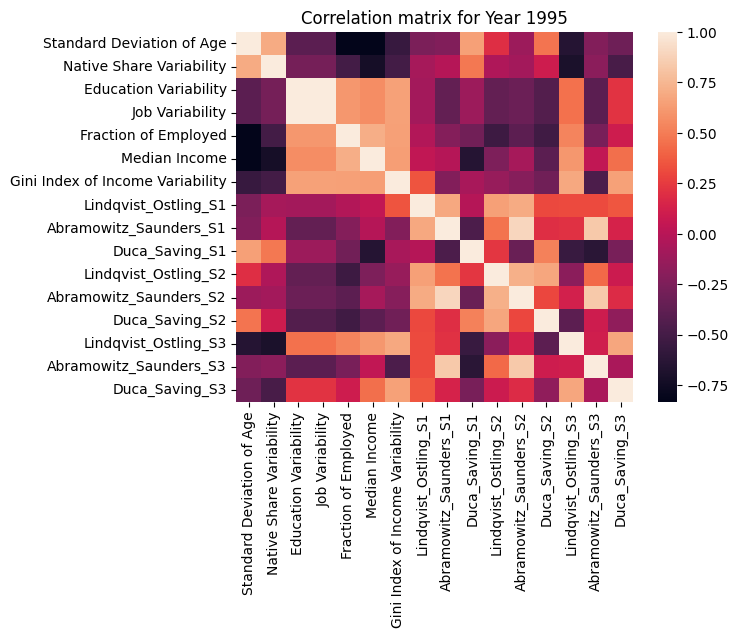

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = output_df.corr()
sns.heatmap(corr_matrix)
plt.title("Correlation matrix for Year 1995")
plt.show()

Text(0.5, 1.0, 'Distribution of opinions for Statement 3 in 1995')

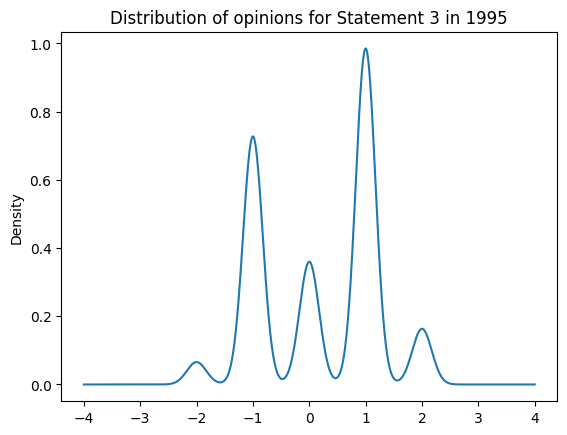

In [24]:
df_residence["eopsoce_encoded"].plot(kind = "kde")
plt.title("Distribution of opinions for Statement 3 in 1995")

Text(0.5, 1.0, 'Distribution of opinions for Statement 3 in 1995')

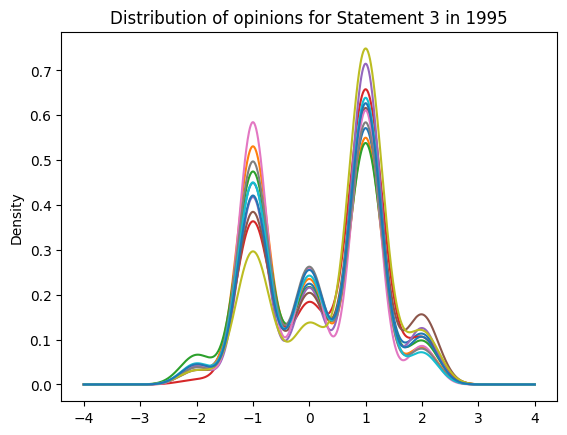

In [25]:
df_residence.groupby("eregion2")["eopsoce_encoded"].plot(kind = "kde")
plt.title("Distribution of opinions for Statement 3 in 1995")

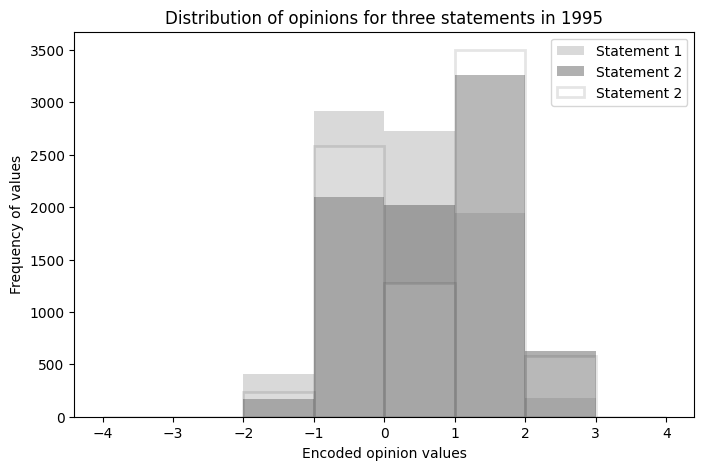

In [26]:
import matplotlib.pyplot as plt

# create the figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# plot the histograms with different colors and alphas
ax.hist(df_residence["eopsocc_encoded"], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color='#d9d9d9')
ax.hist(df_residence["eopsocd_encoded"], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color='#636363', alpha = 0.5)
ax.hist(df_residence["eopsoce_encoded"], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color='white', alpha = 0.1, edgecolor='black', linewidth = 2)

# set title and axis labels
ax.set_title('Distribution of opinions for three statements in 1995')
ax.set_xlabel('Encoded opinion values')
ax.set_ylabel('Frequency of values')

# add a legend
ax.legend(['Statement 1', 'Statement 2', 'Statement 2'], loc='upper right')

plt.show()

In [12]:
output_df.to_csv("polarization1995_data.csv")

## Polarization module

In [ ]:
class polarization:
    def __init__(self, file_path, var_list, education_dict):
        self.file_path = file_path
        self.var_list = var_list